In [1]:
# Default libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]


# Text cleaning & Visualization Libraries
import string
import spacy
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
import emoji
from nltk.probability import FreqDist
from wordcloud import WordCloud


# LDA Libraries
import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


# Other Libraries
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('twitter_tweets.csv')

In [3]:
data

,tweet_id,user_id,twitter_handle,user_location,created_at,text,source
0,1489771544540758020,65541443,RagingBootleg,NaN,2022-02-05 01:23:09,I'm live Playing Pokémon Legends: Arceus! Alpha Pokemon Squad! Tune in and say hello in chat. #Twitch… https://t.co/Y4x0D2FpDr,Twitter Web App
1,1489771387631902720,1479446310495399938,RealCleanCasual,NaN,2022-02-05 01:22:32,The Pokemon Legends: Arceus Iceberg Explained\n#Pokemon #PokemonLegendsArceus \nhttps://t.co/AXhp6pjCFn,Twitter Web App
2,1489770857681592322,1477297237692723200,RedKnight777000,NaN,2022-02-05 01:20:25,Hey y'all! Will be going live with part 2 of Pokemon: Legends Arceus in a bit! I am loving this game sm rn and I re… https://t.co/IIanjGa3Jn,Twitter Web App
3,1489768225621659656,1458172674660786180,chambers_irl,NaN,2022-02-05 01:09:58,I'm live right now on my Hisuian Bear Grylls shit in Pokémon Legends Arceus!! Click the link and come hang!!… https://t.co/oPIvFBkqrJ,Twitter Web App
4,1489768204943736833,975635974939140096,KungFuPenguinTV,NaN,2022-02-05 01:09:53,Will we get our 1st shiny tonight on Pokémon Legends Arceus?!\nLive on @Twitch.\n#Kungfupenguin #twitch… https://t.co/gDZm0VZUlU,Flamingo for Android
...,...,...,...,...,...,...,...
3975,1486853528400375813,734866610,DenofGeekUS,New York,2022-01-28 00:08:00,Just HOW open is the open world of #PokemonLegendsArceus? \nhttps://t.co/kAkkKGfaYc,TweetDeck
3976,1486852521734053888,58987650,oliverwinfree,"Sydney, Australia",2022-01-28 00:04:00,Who's excited for Pokemon Legends Arceus? And which starter would you pick? I always go for fire starters so Cyndaq… https://t.co/pipwmGuHEa,Twitter for Android
3977,1486852459804852228,136863216,TsakuraWataame,"Mesa, AZ",2022-01-28 00:03:45,"Time to tryout ""Pokemon Legends: Arceus""! #Switch #PokemonLegendsArceus https://t.co/KE9rqv2Gy2",Twitter Web App
3978,1486852071903186957,226251614,Pokecharms,NaN,2022-01-28 00:02:12,#PokemonLegendsArceus is now available here in the UK! We've been lucky enough to get a couple days of a head start… https://t.co/1fxDsCoo6A,Twitter Web App


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3980 entries, 0 to 3979
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        3980 non-null   int64 
 1   user_id         3980 non-null   int64 
 2   twitter_handle  3980 non-null   object
 3   user_location   2500 non-null   object
 4   created_at      3980 non-null   object
 5   text            3980 non-null   object
 6   source          3980 non-null   object
dtypes: int64(2), object(5)
memory usage: 217.8+ KB


In [5]:
data.isna().sum()

tweet_id             0
user_id              0
twitter_handle       0
user_location     1480
created_at           0
text                 0
source               0
dtype: int64

In [6]:
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
stop_words = nltk.corpus.stopwords.words('english')
gensim_sw = STOPWORDS
sklearn_sw = ENGLISH_STOP_WORDS
newStopWords = ['pokémon', 'legends', 'PokemonLegendsArceus', 'pokemon', 'ExplainedPokemon', 'pokemonlegendsarceus', 'pokemonlegends', 'legendsarceus', 'arceus']

stop_words.extend(sw_spacy)
stop_words.extend(gensim_sw)
stop_words.extend(sklearn_sw)
stop_words.extend(newStopWords)
stop_words = set(stop_words)

In [7]:
def emoji_cleaning(text):
    emoji_list = [c for c in text if c in emoji.UNICODE_EMOJI] # search for emojis
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text


def text_cleaning(text):
    text = str(text) # Convert into string
    text = text.lower() # Lowercasing text
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'#', '', text) # remove the '#' symbol
    text = re.sub(r'https?://\S+|www\.\S+', "", text) # Remove hyper link
    text = re.sub(r'\n', '', text) # remove line breaks
    
    tokenizer = RegexpTokenizer(r'\w+') # tokenize text & remove punctuations
    tokened_text = tokenizer.tokenize(text)
    
    text = [w for w in tokened_text if w not in stop_words] # Remove stop words
    lemmatizer = WordNetLemmatizer()
    new_text = [lemmatizer.lemmatize(w) for w in text]
    
    return new_text

In [8]:
cleaned_tweets = data['text'].apply(emoji_cleaning)
cleaned_tweets = cleaned_tweets.apply(text_cleaning)
cleaned_tweets

0       [live, playing, alpha, squad, tune, hello, cha...
1                                    [iceberg, explained]
2           [hey, going, live, bit, loving, game, sm, rn]
3       [live, right, hisuian, bear, grylls, shit, cli...
4       [st, shiny, tonight, live, twitch, kungfupengu...
                              ...                        
3975                                  [open, open, world]
3976            [excited, starter, pick, starter, cyndaq]
3977                               [time, tryout, switch]
3978     [available, uk, lucky, couple, day, head, start]
3979                    [occasion, release, drawing, ago]
Name: text, Length: 3980, dtype: object

In [9]:
flat_words = [item for sublist in cleaned_tweets for item in sublist]
word_freq = FreqDist(flat_words)

word_freq.most_common(30)

[('live', 599),
 ('game', 551),
 ('playing', 369),
 ('new', 356),
 ('come', 308),
 ('stream', 293),
 ('time', 273),
 ('twitch', 264),
 ('play', 262),
 ('shiny', 250),
 ('let', 241),
 ('day', 226),
 ('today', 219),
 ('going', 198),
 ('nintendoswitch', 194),
 ('youtube', 183),
 ('streaming', 167),
 ('got', 152),
 ('pm', 145),
 ('nintendo', 144),
 ('tonight', 133),
 ('join', 132),
 ('like', 132),
 ('finally', 130),
 ('love', 116),
 ('switch', 116),
 ('hour', 115),
 ('spoiler', 113),
 ('check', 113),
 ('video', 106)]

In [10]:
most_common_count = [x[1] for x in word_freq.most_common(30)]
most_common_word = [x[0] for x in word_freq.most_common(30)]

#create dictionary mapping of word count
top_30_dictionary = dict(zip(most_common_word, most_common_count))

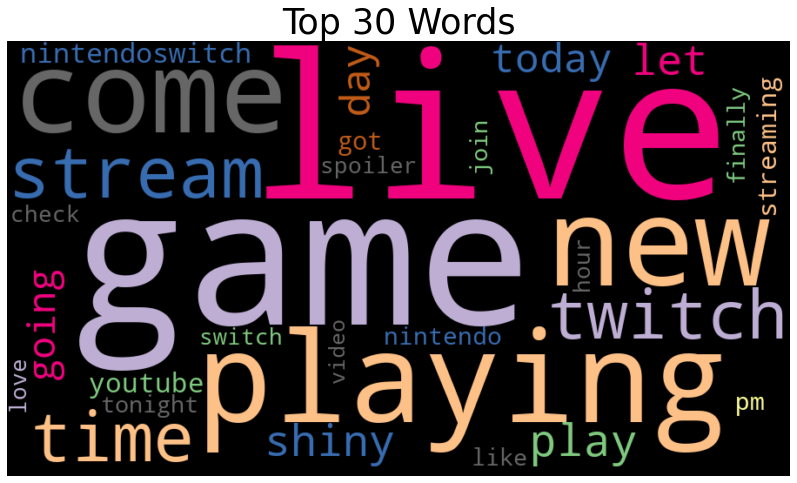

In [11]:
genres_cloud = WordCloud(width=900, height=500, background_color='black', colormap='Accent', max_words=10000).generate_from_frequencies(top_30_dictionary)

plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 30 Words',fontsize = 35)
plt.show();

In [12]:
dictionary = Dictionary(cleaned_tweets)

texts = cleaned_tweets

corpus = [dictionary.doc2bow(text) for text in texts]

In [13]:
tweets_lda = LdaMulticore(corpus, num_topics=7, id2word=dictionary, random_state=1)

tweets_lda.show_topics()

[(0,
  '0.019*"new" + 0.016*"playing" + 0.015*"today" + 0.014*"game" + 0.010*"day" + 0.007*"shiny" + 0.007*"pm" + 0.007*"like" + 0.006*"stream" + 0.006*"got"'),
 (1,
  '0.029*"nintendoswitch" + 0.018*"game" + 0.013*"day" + 0.013*"stream" + 0.012*"live" + 0.012*"time" + 0.011*"twitch" + 0.008*"spoiler" + 0.006*"playing" + 0.006*"shiny"'),
 (2,
  '0.034*"live" + 0.024*"come" + 0.024*"playing" + 0.018*"shiny" + 0.018*"twitch" + 0.018*"time" + 0.017*"game" + 0.013*"let" + 0.010*"going" + 0.009*"youtube"'),
 (3,
  '0.026*"game" + 0.017*"live" + 0.011*"copy" + 0.011*"switch" + 0.010*"twitch" + 0.010*"streaming" + 0.008*"nintendo" + 0.008*"stream" + 0.008*"playing" + 0.007*"catch"'),
 (4,
  '0.039*"live" + 0.021*"game" + 0.020*"new" + 0.017*"playing" + 0.013*"going" + 0.012*"youtube" + 0.010*"today" + 0.009*"let" + 0.008*"streaming" + 0.008*"play"'),
 (5,
  '0.030*"play" + 0.027*"stream" + 0.020*"come" + 0.018*"live" + 0.014*"let" + 0.013*"game" + 0.013*"join" + 0.012*"today" + 0.010*"time" +

In [14]:
lda_viz = gensimvis.prepare(tweets_lda, corpus, dictionary)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.062451 -0.027530       1        1  20.644343
5      0.081341  0.057056       2        1  16.255580
4      0.012019  0.006127       3        1  14.811776
6     -0.020531  0.013254       4        1  13.156657
0     -0.075790  0.071180       5        1  11.972643
1     -0.001857 -0.076188       6        1  11.945291
3     -0.057634 -0.043898       7        1  11.213710, topic_info=               Term        Freq       Total Category  logprob  loglift
193  nintendoswitch  160.000000  160.000000  Default  30.0000  30.0000
39             play  229.000000  229.000000  Default  29.0000  29.0000
57              new  303.000000  303.000000  Default  28.0000  28.0000
3              live  511.000000  511.000000  Default  27.0000  27.0000
52           stream  253.000000  253.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
12            going   12.141583  169.562774   Topic7  -5.4264  -0.4486
298            hour   10.881052   98.116734   Topic7  -5.5360  -0.0111
63             best   10.052081   75.029350   Topic7  -5.6153   0.1779
57              new   10.419979  303.483460   Topic7  -5.5793  -1.1836
39             play   10.060839  229.805476   Topic7  -5.6144  -0.9405

[562 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2960      7  0.799030        act
140       1  0.057710  adventure
140       2  0.207755  adventure
140       3  0.103878  adventure
140       4  0.484763  adventure
...     ...       ...        ...
54        7  0.115552    youtube
1277      6  0.821468   youtuber
3841      1  0.766034       yumi
3114      3  0.805773          ฅ
2903      5  0.800050          ﾟ

[1269 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 5, 7, 1, 2, 4])